# BIDS Loader


We use the data in `SpineGeneric`

In [1]:
from bids_neuropoly import bids
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms
from medicaltorch import filters as mt_filters

from PIL import Image


class SliceFilter(mt_filters.SliceFilter):
    """This class extends the SliceFilter that already
    filters for empty labels and inputs. It will filter
    slices that has only zeros after cropping. To avoid
    feeding empty inputs into the network.
    """
    def __call__(self, sample):
        super_ret = super().__call__(sample)

        # Already filtered by base class
        if not super_ret:
            return super_ret

        # Filter slices where there are no values after cropping
        input_img = Image.fromarray(sample['input'], mode='F')
        input_cropped = transforms.functional.center_crop(input_img, (128, 128))
        input_cropped = np.array(input_cropped)
        count = np.count_nonzero(input_cropped)

        if count <= 0:
            return False

        return True
    
class BIDSSegPair2D(mt_datasets.SegmentationPair2D):
    def __init__(self, input_filename, gt_filename, metadata):
        super().__init__(input_filename, gt_filename)
        self.metadata = metadata
        self.metadata["input_filename"] = input_filename
        self.metadata["gt_filename"] = gt_filename

    def get_pair_slice(self, slice_index, slice_axis=2):
        dreturn = super().get_pair_slice(slice_index, slice_axis)
        self.metadata["slice_index"] = slice_index
        dreturn["input_metadata"]["bids_metadata"] = self.metadata
        return dreturn


class MRI2DBidsSegDataset(mt_datasets.MRI2DSegmentationDataset):
    def _load_filenames(self):
        for input_filename, gt_filename, bids_metadata in self.filename_pairs:
            segpair = BIDSSegPair2D(input_filename, gt_filename,
                                    bids_metadata)
            self.handlers.append(segpair)


class BidsDataset(MRI2DBidsSegDataset):
    def __init__(self, root_dir, slice_axis=2, cache=True,
                 transform=None, slice_filter_fn=None,
                 canonical=False, labeled=True):
        self.bids_ds = bids.BIDS(root_dir)
        self.filename_pairs = []
        self.metadata = {"FlipAngle": [], "RepetitionTime": [], "EchoTime": [], "Manufacturer": []}

        for subject in self.bids_ds.get_subjects():

            if not subject.has_derivative("labels"):
                print("Subject without derivative, skipping.")
                continue
            derivatives = subject.get_derivatives("labels")
            cord_label_filename = None

            for deriv in derivatives:
                if deriv.endswith("seg-manual.nii.gz"):
                    cord_label_filename = deriv

            if cord_label_filename is None:
                continue

            if not subject.has_metadata():
                print("Subject without metadata.")
                continue

            metadata = subject.metadata()
            

            self.filename_pairs.append((subject.record.absolute_path,
                                        cord_label_filename, metadata))

        super().__init__(self.filename_pairs, slice_axis, cache,
                         transform, slice_filter_fn, canonical)


# Model

Here we define the architecture of the network in a PyTorch Module

In [2]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class DownConv(nn.Module):
    def __init__(self, in_ch, out_ch, drop_rate=0.2, bn_momentum=0.1):
        super(DownConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, stride=1, padding=1)
        self.conv_bn = nn.BatchNorm2d(out_ch, momentum=bn_momentum)
        self.conv_drop = nn.Dropout2d(drop_rate)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.conv_bn(x)
        x = self.conv_drop(x)
        return x

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class Classifier(nn.Module):
    def __init__(self, drop_rate=0.2, bn_momentum=0.1):
        super(Classifier, self).__init__()
        self.conv1 = DownConv(1, 32, drop_rate, bn_momentum)
        self.mp1 = nn.MaxPool2d(2)
        
        self.conv2 = DownConv(32, 32, drop_rate, bn_momentum)
        self.mp2 = nn.MaxPool2d(2)
        
        self.conv3 = DownConv(32, 64, drop_rate, bn_momentum)
        self.mp3 = nn.MaxPool2d(2)       
        
        self.flat = Flatten()
        self.dense1 = nn.Linear(16384, 512)
        self.drop = nn.Dropout2d(drop_rate)
        self.dense2 = nn.Linear(512, 6)
        self.soft = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.mp1(x1)
        
        x3 = self.conv2(x2)
        x4 = self.mp2(x3)
        
        x5 = self.conv3(x4)
        x6 = self.mp3(x5)
        
        x7 = self.flat(x6)
        x8 = F.relu(self.dense1(x7))
        x9 = self.drop(x8)
        x10 = self.dense2(x9)
        x11 = self.soft(x10)

        return(x11)

#torch tensors are of the format (batch_size, n_channels, shape_of_image)
a = torch.rand(18,1,128,128)
test = Classifier().forward(a)

# Training the model

In [39]:
from tensorboardX import SummaryWriter
import time
import shutil
import sys
import pickle
import nibabel as nib
import numpy as np
import json
import os
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from skimage.transform import resize

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, ConcatDataset

import torch.backends.cudnn as cudnn
cudnn.benchmark = True



def get_modality(batch):
    labels = []
    for acq in batch['input_metadata']:
        path = acq.__getitem__('bids_metadata')['input_filename']
        name = os.path.basename(path)
        if "acq-MToff_MTS" in name :
            labels.append(0)
            continue
        if "acq-MTon_MTS" in name :
            labels.append(1)
            continue
        if "acq-T1w_MTS" in name :
            labels.append(2)
            continue
        if "T1w" in name :
            labels.append(3)
            continue
        if "T2star" in name :
            labels.append(4)
            continue
        if "T2w" in name :
            labels.append(5) 
            continue
    return labels

def OneHotEncode(labels):
    ohe_labels = []
    for label in labels :
        ohe = [0 for i in range(6)]
        ohe[label] = 1 
        ohe_labels.append(ohe)
    return torch.cuda.FloatTensor(ohe_labels)


def cmd_train(context):
    """Main command do train the network.
    :param context: this is a dictionary with all data from the
                    configuration file:
                        - 'command': run the specified command (e.g. train, test)
                        - 'gpu': ID of the used GPU
                        - 'bids_path_train': list of relative paths of the BIDS folders of each training center
                        - 'bids_path_validation': list of relative paths of the BIDS folders of each validation center
                        - 'bids_path_test': list of relative paths of the BIDS folders of each test center
                        - 'batch_size'
                        - 'dropout_rate'
                        - 'batch_norm_momentum'
                        - 'num_epochs'
                        - 'initial_lr': initial learning rate
                        - 'log_directory': folder name where log files are saved
                        - 'debugging': allows extended verbosity and intermediate outputs
    """
    # Set the GPU
    gpu_number = int(0)
    torch.cuda.set_device(gpu_number)

    # These are the training transformations
    train_transform = transforms.Compose([
        mt_transforms.CenterCrop2D((128, 128)),
        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.RandomTensorChannelShift((-0.10, 0.10)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
    ])

    # These are the validation/testing transformations
    val_transform = transforms.Compose([
        mt_transforms.CenterCrop2D((128, 128)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
    ])

    # This code will iterate over the folders and load the data, filtering
    # the slices without labels and then concatenating all the datasets together
    train_datasets = []
    for bids_ds in tqdm_notebook(context["bids_path_train"], desc="Loading training set"):
        ds_train = BidsDataset(bids_ds,
                               transform=train_transform,
                               slice_filter_fn=SliceFilter())
        train_datasets.append(ds_train)

    ds_train = ConcatDataset(train_datasets)
    print(f"Loaded {len(ds_train)} axial slices for the training set.")
    train_loader = DataLoader(ds_train, batch_size=context["batch_size"],
                              shuffle=True, pin_memory=True,
                              collate_fn=mt_datasets.mt_collate,
                              num_workers=1)
    
    # Validation dataset ------------------------------------------------------
    validation_datasets = []
    for bids_ds in tqdm_notebook(context["bids_path_validation"], desc="Loading validation set"):
        ds_val = BidsDataset(bids_ds,
                             transform=val_transform,
                             slice_filter_fn=SliceFilter())
        validation_datasets.append(ds_val)

    ds_val = ConcatDataset(validation_datasets)
    print(f"Loaded {len(ds_val)} axial slices for the validation set.")
    val_loader = DataLoader(ds_val, batch_size=context["batch_size"],
                            shuffle=True, pin_memory=True,
                            collate_fn=mt_datasets.mt_collate,
                            num_workers=0)
    
    
    # Model definition ---------------------------------------------------------
    model = Classifier(drop_rate=context["dropout_rate"],
                       bn_momentum=context["batch_norm_momentum"])

    model.cuda()

    num_epochs = context["num_epochs"]
    initial_lr = context["initial_lr"]

    # Using SGD with cosine annealing learning rate
    optimizer = optim.SGD(model.parameters(), lr=initial_lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

    # Write the metrics, images, etc to TensorBoard format
    writer = SummaryWriter(log_dir=context["log_directory"])
    
    # Binary Cross Entropy Loss
    criterion = nn.CrossEntropyLoss()
    
    
    # Training loop -----------------------------------------------------------
    best_validation_loss = float("inf")
    
    lst_train_loss = []
    lst_val_loss = []
    lst_accuracy = []
    
    for epoch in tqdm_notebook(range(1, num_epochs+1), desc="Training"):
        start_time = time.time()

        scheduler.step()

        lr = scheduler.get_lr()[0]
        writer.add_scalar('learning_rate', lr, epoch)

        model.train()
        train_loss_total = 0.0
        num_steps = 0
    
        for i, batch in enumerate(train_loader):
            input_samples = batch["input"]
            input_labels = get_modality(batch)
            
            var_input = input_samples.cuda()
            var_labels = torch.cuda.LongTensor(input_labels).cuda(non_blocking=True)

            outputs = model(var_input)
            
            loss = criterion(outputs, var_labels)
            train_loss_total += loss.item()

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()
            num_steps += 1
            
        train_loss_total_avg = train_loss_total / num_steps
        lst_train_loss.append(train_loss_total_avg)
        
        #tqdm.write(f"Epoch {epoch} training loss: {train_loss_total_avg:.4f}.")
        print(f"Epoch {epoch} training loss: {train_loss_total_avg:.4f}.")
        
        
        # Validation loop -----------------------------------------------------
        model.eval()
        val_loss_total = 0.0
        num_steps = 0
        
        val_accuracy = 0
        num_samples = 0
        
        for i, batch in enumerate(val_loader):
            input_samples = batch["input"]
            input_labels = get_modality(batch)
            
            with torch.no_grad():
                var_input = input_samples.cuda()
                var_labels = torch.cuda.LongTensor(input_labels).cuda(non_blocking=True)

                outputs = model(var_input)
                _, preds = torch.max(outputs, 1)

                loss = criterion(outputs, var_labels)
                val_loss_total += loss.item()
                
                val_accuracy += int((var_labels == preds).sum())
                
            num_steps += 1
            num_samples += context['batch_size']
            
        val_loss_total_avg = val_loss_total / num_steps
        lst_val_loss.append(val_loss_total_avg)
        
        #tqdm.write(f"Epoch {epoch} validation loss: {val_loss_total_avg:.4f}.")
        print(f"Epoch {epoch} validation loss: {val_loss_total_avg:.4f}.")
        
        val_accuracy_avg = 100 * val_accuracy / num_samples
        lst_accuracy.append(val_accuracy_avg)
        
        #tqdm.write(f"Epoch {epoch} accuracy : {val_accuracy_avg:.4f}.")
        print(f"Epoch {epoch} accuracy : {val_accuracy_avg:.4f} %.")
        
        end_time = time.time()
        total_time = end_time - start_time
        #tqdm.write("Epoch {} took {:.2f} seconds.".format(epoch, total_time))
        print("Epoch {} took {:.2f} seconds.".format(epoch, total_time))
        
        
        if val_loss_total_avg < best_validation_loss:
            best_validation_loss = val_loss_total_avg
            torch.save(model, "./"+context["log_directory"]+"/best_model.pt")

        
    # save final model
    torch.save(model, "./"+context["log_directory"]+"/final_model.pt")
    
    # display and save the metrics
    parameters = "CrossEntropyLoss, batchsize=" + str(context['batch_size'])
    parameters += ", initial_lr=" + str(context['initial_lr'])
    parameters += ", dropout=" + str(context['dropout_rate'])
    
    
    plt.subplot(2,1,1)
    plt.title(parameters)
    plt.plot(lst_train_loss, color='red', label='Training')
    plt.plot(lst_val_loss, color='blue', label='Validation')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    
    plt.subplot(2,1,2)
    plt.plot(lst_accuracy)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.savefig(parameters+'.png')
    plt.show()    
    return


def run_main(command):
    with open('config_small.json') as fhandle:
        context = json.load(fhandle)

    #command = context["command"]

    if command == 'train':
        cmd_train(context)
        #shutil.copyfile(sys.argv[1], "./"+context["log_directory"]+"/config_file.json")
    elif command == 'test':
        cmd_test(context)

    

Loaded 3518 axial slices for the training set.


Loaded 2948 axial slices for the validation set.


Epoch 1 training loss: 1.4957.
Epoch 1 validation loss: 1.4231.
Epoch 1 accuracy : 68.3784 %.
Epoch 1 took 37.71 seconds.
Epoch 2 training loss: 1.2851.
Epoch 2 validation loss: 1.3445.
Epoch 2 accuracy : 71.8243 %.
Epoch 2 took 37.19 seconds.
Epoch 3 training loss: 1.2125.
Epoch 3 validation loss: 1.3092.
Epoch 3 accuracy : 75.2027 %.
Epoch 3 took 37.40 seconds.
Epoch 4 training loss: 1.1815.
Epoch 4 validation loss: 1.2939.
Epoch 4 accuracy : 75.1689 %.
Epoch 4 took 37.73 seconds.
Epoch 5 training loss: 1.1624.
Epoch 5 validation loss: 1.2612.
Epoch 5 accuracy : 78.7838 %.
Epoch 5 took 37.61 seconds.
Epoch 6 training loss: 1.1462.
Epoch 6 validation loss: 1.2526.
Epoch 6 accuracy : 80.0676 %.
Epoch 6 took 37.74 seconds.
Epoch 7 training loss: 1.1396.
Epoch 7 validation loss: 1.2255.
Epoch 7 accuracy : 82.2297 %.
Epoch 7 took 37.46 seconds.
Epoch 8 training loss: 1.1300.
Epoch 8 validation loss: 1.2319.
Epoch 8 accuracy : 81.4527 %.
Epoch 8 took 37.41 seconds.
Epoch 9 training loss: 1

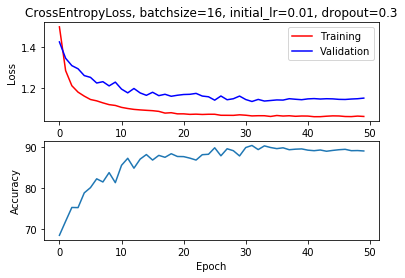

In [40]:
run_main('train')

# Accuracy evaluation

Since we only measured the accuracy over each slice we have to measure the accuracy for a whole acquisition comprising several (at leat 15) tranches. If we consider the label that appears the most among the acquisition we obtain the estimated label for the acquisition.

In [41]:
def tirage():
    x = np.random.rand()
    if x <= 0.84:
        return([0,0,0,0,0,1])
    else:
        i = np.random.randint(4)
        l = [0 for i in range(6)]
        l[i] = 1
        return(l)
    
def montecarlo(n):
    accuracy = 0
    for i in range(n):
        # we average over 15 slices
        labels = [0 for i in range(6)]
        for j in range(15):
            t = tirage()
            labels = [x+y for x,y in zip(labels, t)]
        label = labels.index(max(labels))
        if label == 5:
            accuracy += 1
    return(100 * accuracy/n)
            
montecarlo(10000000)

99.99884

So we manage to obtain a promising 99.988% accuracy for each acquisition, which is enough for a reliable release.

# Random testing

In [ ]:
with open('config_small.json') as fhandle:
    context = json.load(fhandle)

command = context["command"]

if command == 'train':
    cmd_train(context)
    shutil.copyfile(sys.argv[1], "./"+context["log_directory"]+"/config_file.json")
elif command == 'test':
    cmd_test(context)

In [ ]:
preds = torch.rand(18,6)
preds_norm = nn.Softmax()
labels = [4, 5, 1, 3, 2, 5, 2, 5, 0, 3, 1, 0, 4, 0, 3, 0, 5, 3]
var_labels = []
for l in labels :
    a = [0 for i in range(6)]
    a[l] = 1 
    var_labels.append(a)
var_labels = torch.FloatTensor(var_labels)



CS_loss = nn.BCELoss()
loss = CS_loss(var_labels, preds)

NLL = nn.NLLLoss()
loss = NLL(var_labels, preds)
loss

In [ ]:
model = Classifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
next(model.parameters()).is_cuda

In [ ]:
torch.cuda.is_available()

In [ ]:
for i in range(100):
    a = torch.rand(18,1,128,128)
    a = a.cuda()
    t = time.time()
            
    preds = model(a)

    print(f"took {time.time() - t} to compute")
            